# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_first_layer
Gradient check passed!
Checking gradient for B_first_layer
Gradient check passed!
Checking gradient for W_second_layer
Gradient check passed!
Checking gradient for B_second_layer
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_first_layer
Gradient check passed!
Checking gradient for B_first_layer
Gradient check passed!
Checking gradient for W_second_layer
Gradient check passed!
Checking gradient for B_second_layer
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-5)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 4.875661, Train accuracy: 0.104778, val accuracy: 0.128000
Loss: 4.451576, Train accuracy: 0.113667, val accuracy: 0.149000
Loss: 4.097292, Train accuracy: 0.113556, val accuracy: 0.148000
Loss: 3.801706, Train accuracy: 0.114222, val accuracy: 0.147000
Loss: 3.554704, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.348069, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.176513, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 3.031846, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.911985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.811082, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.727266, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.657402, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.599238, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.550130, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.509842, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.474745, Train acc

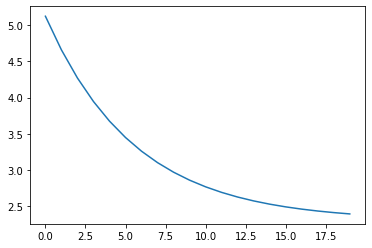

In [10]:
#plt.plot(train_history)
#plt.plot(val_history)
plt.plot(loss_history)

#### Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

print(trainer.learning_rate, initial_learning_rate)
assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217454, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256101, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-5, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.332475, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.330697, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331218, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324256, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324296, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328764, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321874, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323516, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320783, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321889, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320508, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326444, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315414, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.322014, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320650, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317119, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.449330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.304464, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.494726, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.327706, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.361608, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.460816, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.424061, Train accuracy: 1.000000, val accuracy: 0.000000


Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [14]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.70, num_epochs=20, batch_size=200)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.302580, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.276438, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.252054, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.221621, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.149885, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.936144, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.682939, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.687199, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 1.903336, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.915354, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 1.846924, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.638507, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.473848, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.318241, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.339796, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.267187, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
def cartesian_product(arrays):
    la = len(arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=np.float)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, 5)

In [25]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 128

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

params = []

#learning_rates = [1e-3, 1e-1]
#reg_strengths = [1e-5, 1e-7, 1e-2]
#learning_rate_decays = [0.8]
#hidden_layer_sizes = [100]
#momentums = [0.3, 0.1]
#best = [1e-1, 1e-7, 0.8, 100, 0.3]

#learning_rates = [1e-1]
#reg_strengths =  [1e-7, 1e-8]
#learning_rate_decays = [0.8, 0.9]
#hidden_layer_sizes = [100]
#momentums = [0.3, 0.5]
# best [0.1, 1e-07, 0.9, 100.0, 0.5]
learning_rates = [1e-1]
reg_strengths = [1e-7]
learning_rate_decays = [0.9]
hidden_layer_sizes = [100]
momentums = [0.3]
hyper_parametrs = cartesian_product((learning_rates, reg_strengths,learning_rate_decays, hidden_layer_sizes, momentums))
#print(hyper_parametrs)
for hyper_parametr in hyper_parametrs:
    lr = hyper_parametr[0]
    reg = hyper_parametr[1]
    lr_dec = hyper_parametr[2]
    hid_l_size = hyper_parametr[3]
    momentum = hyper_parametr[4]
    
    dataset = Dataset(train_X, train_y, val_X, val_y)
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = np.int(hid_l_size), reg = reg)
    trainer = Trainer(model, dataset, MomentumSGD(momentum=momentum), learning_rate=lr, num_epochs=20, batch_size=200, learning_rate_decay = lr_dec)
    loss_history1, train_history1, val_history1 = trainer.fit()
    max_val = np.max(val_history1)
    if max_val > best_val_accuracy:
        best_val_accuracy = max_val
        loss_history = loss_history1
        train_history = train_history1
        val_history = val_history1
        best_classifier = model
        params = [lr, reg, lr_dec, hid_l_size, momentum]
# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)
print(params)

Loss: 2.265198, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.053438, Train accuracy: 0.263444, val accuracy: 0.265000
Loss: 1.858351, Train accuracy: 0.393222, val accuracy: 0.385000
Loss: 1.557612, Train accuracy: 0.507556, val accuracy: 0.513000
Loss: 1.187907, Train accuracy: 0.611333, val accuracy: 0.595000
Loss: 1.142799, Train accuracy: 0.654778, val accuracy: 0.640000
Loss: 1.097432, Train accuracy: 0.675556, val accuracy: 0.654000
Loss: 0.915770, Train accuracy: 0.699000, val accuracy: 0.683000
Loss: 0.947884, Train accuracy: 0.720111, val accuracy: 0.682000
Loss: 0.999473, Train accuracy: 0.739889, val accuracy: 0.697000
Loss: 0.890966, Train accuracy: 0.753111, val accuracy: 0.700000
Loss: 0.776308, Train accuracy: 0.766444, val accuracy: 0.715000
Loss: 0.670678, Train accuracy: 0.770556, val accuracy: 0.714000
Loss: 0.835808, Train accuracy: 0.782889, val accuracy: 0.717000
Loss: 0.760003, Train accuracy: 0.791778, val accuracy: 0.722000
Loss: 0.793599, Train acc

In [19]:
print(params)

[0.1, 1e-07, 0.8, 100.0, 0.3]


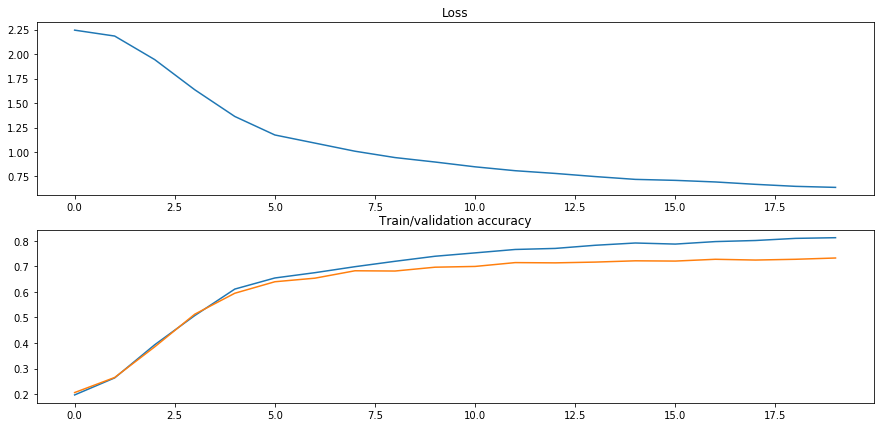

In [26]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [27]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.696000
